In [1]:
!apt install cmake libboost-all-dev libsdl2-dev libfreetype6-dev libgl1-mesa-dev libglu1-mesa-dev libpng-dev libjpeg-dev libbz2-dev libfluidsynth-dev libgme-dev libopenal-dev zlib1g-dev timidity tar nasm
!pip install vizdoom==1.1.9

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglu1-mesa-dev is already the newest version (9.0.0-2.1build1).
libglu1-mesa-dev set to manually installed.
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libboost-all-dev is already the newest version (1.65.1.0ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
libbz2-dev is already the newest version (1.0.6-8.1ubuntu0.2).
libbz2-dev set to manually installed.
libfreetype6-dev is already the newest version (2.8.1-2ubuntu2.1).
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-dev set to manually installed.
libpng-dev is already the newest version (1.6.34-1ubuntu0.18.04.2).
The following additional packages will be installed:
  freepats gir1.2-ibus-1.0 libaudio2 libcapnp-0.6.1 libdbus

In [2]:
import vizdoom as vzd
from vizdoom import Mode
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import itertools as it
import skimage.transform
from time import sleep, time
from collections import deque
from tqdm import trange

import PIL
import numpy as np
import os

import json
import zipfile
import os.path

from torchvision import models
import torchvision.transforms as T
from PIL import Image

In [3]:
KAGGLE_DIR = '/root/.kaggle'
KAGGLE_JSON = '/root/.kaggle/kaggle.json'

!rm -rf $KAGGLE_DIR
!mkdir $KAGGLE_DIR
!touch $KAGGLE_JSON

# for further information check:
# 1) https://stackoverflow.com/questions/56816537/cant-find-kaggle-json-file-in-google-colab
# 2) https://github.com/Kaggle/kaggle-api#api-credentials
api_token = {"username":"alejandromp12","key":"3e66a7513e5ca8e651ba775382b06f3b"}

with open(KAGGLE_JSON, 'w') as file:
    json.dump(api_token, file)

!chmod 600 $KAGGLE_JSON

# directory that contains vizdoom
directory_vizdoom = '/content/ViZDoom-master/ViZDoom-master'
if os.path.exists(directory_vizdoom):
  print("VIZDoom already downloaded!")
else:
  !kaggle datasets download --unzip -p /content/ alejandromp12/myweightsganstask

  0% 0.00/5.71M [00:00<?, ?B/s]
100% 5.71M/5.71M [00:00<00:00, 52.7MB/s]


In [4]:
# Q-learning settings
learning_rate = 0.00025
discount_factor = 0.99
train_epochs = 10 #5
learning_steps_per_epoch = 2000
replay_memory_size = 10000

# NN learning settings
batch_size = 64

# Training regime
test_episodes_per_epoch = 100

# Other parameters
frame_repeat = 12
resolution = (30, 45)
episodes_to_watch = 10

model_savefile = "/content/model-doom.pth"
model_savefile_preproc = "/content/model-doom-prepossed.pth"
model_savefile_base = "/content/model-doom-base.pth"
save_model = True
load_model = False
skip_learning = False

# Uses GPU if available
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
else:
    DEVICE = torch.device('cpu')

In [5]:
class DuelQNet(nn.Module):
    """
    This is Duel DQN architecture.
    see https://arxiv.org/abs/1511.06581 for more information.
    """
    def __init__(self, available_actions_count):
        super(DuelQNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=2, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout2d(),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout2d(),
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout2d(),
            nn.ReLU()
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout2d(),
            nn.ReLU()
        )

        self.state_fc = nn.Sequential(
            nn.Linear(40, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.advantage_fc = nn.Sequential(
            nn.Linear(40, 64),
            nn.ReLU(),
            nn.Linear(64, available_actions_count)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 80)
        x1 = x[:, :40]  # input for the net to calculate the state value
        x2 = x[:, 40:]  # relative advantage of actions in the state
        state_value = self.state_fc(x1).reshape(-1, 1)
        advantage_values = self.advantage_fc(x2)
        x = state_value + (advantage_values - advantage_values.mean(dim=1).reshape(-1, 1))

        return x


class DQNAgent:
    def __init__(self, action_size, memory_size, batch_size, discount_factor, 
                 lr, load_model, model_file, epsilon=1, epsilon_decay=0.9996, epsilon_min=0.1):
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.discount = discount_factor
        self.lr = lr
        self.memory = deque(maxlen=memory_size)
        self.criterion = nn.MSELoss()

        if load_model:
            print("Loading model from: ", model_file)
            self.q_net = torch.load(model_file)
            self.target_net = torch.load(model_file)
            self.epsilon = self.epsilon_min

        else:
            print("Initializing new model")
            self.q_net = DuelQNet(action_size).to(DEVICE)
            self.target_net = DuelQNet(action_size).to(DEVICE)

        self.opt = optim.SGD(self.q_net.parameters(), lr=self.lr)

    def get_action(self, state):
        if np.random.uniform() < self.epsilon:
            return random.choice(range(self.action_size))
        else:
            state = np.expand_dims(state, axis=0)
            state = torch.from_numpy(state).float().to(DEVICE)
            action = torch.argmax(self.q_net(state)).item()
            return action

    def update_target_net(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

    def append_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        batch = random.sample(self.memory, self.batch_size)
        batch = np.array(batch, dtype=object)

        states = np.stack(batch[:, 0]).astype(float)
        actions = batch[:, 1].astype(int)
        rewards = batch[:, 2].astype(float)
        next_states = np.stack(batch[:, 3]).astype(float)
        dones = batch[:, 4].astype(bool)
        not_dones = ~dones

        row_idx = np.arange(self.batch_size)  # used for indexing the batch

        # value of the next states with double q learning
        # see https://arxiv.org/abs/1509.06461 for more information on double q learning
        with torch.no_grad():
            next_states = torch.from_numpy(next_states).float().to(DEVICE)
            idx = row_idx, np.argmax(self.q_net(next_states).cpu().data.numpy(), 1)
            next_state_values = self.target_net(next_states).cpu().data.numpy()[idx]
            next_state_values = next_state_values[not_dones]

        # this defines y = r + discount * max_a q(s', a)
        q_targets = rewards.copy()
        q_targets[not_dones] += self.discount * next_state_values
        q_targets = torch.from_numpy(q_targets).float().to(DEVICE)

        # this selects only the q values of the actions taken
        idx = row_idx, actions
        states = torch.from_numpy(states).float().to(DEVICE)
        action_values = self.q_net(states)[idx].float().to(DEVICE)

        self.opt.zero_grad()
        td_error = self.criterion(q_targets, action_values)
        td_error.backward()
        self.opt.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min

In [6]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.filters

def capture_just_actor_and_enemy(img):
  # blur the image to denoise
  blurred_image = skimage.filters.gaussian(img, sigma=1.0)
  if blurred_image.min() == blurred_image.max():
    #print("The input image seems to have just one color")
    return blurred_image
  # perform automatic thresholding to produce a binary image
  t = skimage.filters.threshold_otsu(blurred_image)
  binary_mask = blurred_image > t
  return binary_mask

def reduce_resolution(img):
    """Down samples image to resolution"""
    img = skimage.transform.resize(img, resolution)
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    return img

def preprocess(img):
    img = capture_just_actor_and_enemy(img)
    img = reduce_resolution(img)
    return img

def create_simple_game(config_file_path, train_mode = False):
    print("Initializing doom...")
    game = vzd.DoomGame()
    game.load_config(config_file_path)
    game.set_window_visible(False)
    game.set_mode(Mode.PLAYER)
    game.set_screen_format(vzd.ScreenFormat.GRAY8)
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
    if train_mode is True:
      # Enables depth buffer.
      game.set_depth_buffer_enabled(True)
      # Enables labeling of in game objects labeling.
      game.set_labels_buffer_enabled(True)
    game.init()
    print("Doom initialized.")

    return game

def test(game, agent, actions):
    """Runs a test_episodes_per_epoch episodes and prints the result"""
    print("\nTesting...")
    test_scores = []
    for test_episode in trange(test_episodes_per_epoch, leave=False):
        game.new_episode()
        while not game.is_episode_finished():
            state = preprocess(game.get_state().screen_buffer)
            best_action_index = agent.get_action(state)

            game.make_action(actions[best_action_index], frame_repeat)
        r = game.get_total_reward()
        test_scores.append(r)

    test_scores = np.array(test_scores)
    print("Results: mean: %.1f +/- %.1f," % (
        test_scores.mean(), test_scores.std()), "min: %.1f" % test_scores.min(),
          "max: %.1f" % test_scores.max())


def run(game, agent, actions, num_epochs, frame_repeat, steps_per_epoch=2000):
    """
    Run num epochs of training episodes.
    Skip frame_repeat number of frames after each action.
    """

    start_time = time()

    for epoch in range(num_epochs):
        game.new_episode()
        train_scores = []
        global_step = 0
        print("\nEpoch #" + str(epoch + 1))

        for _ in trange(steps_per_epoch, leave=False):
            state = preprocess(game.get_state().labels_buffer)
            action = agent.get_action(state)
            reward = game.make_action(actions[action], frame_repeat)
            done = game.is_episode_finished()

            if not done:
                next_state = preprocess(game.get_state().labels_buffer)
            else:
                next_state = np.zeros((1, 30, 45)).astype(np.float32)

            agent.append_memory(state, action, reward, next_state, done)

            if global_step > agent.batch_size:
                agent.train()

            if done:
                train_scores.append(game.get_total_reward())
                game.new_episode()

            global_step += 1

        agent.update_target_net()
        train_scores = np.array(train_scores)

        print("Results: mean: %.1f +/- %.1f," % (train_scores.mean(), train_scores.std()),
              "min: %.1f," % train_scores.min(), "max: %.1f," % train_scores.max())

        test(game, agent, actions)
        if save_model:
            print("Saving the network weights to:", model_savefile)
            torch.save(agent.q_net, model_savefile)
        print("Total elapsed time: %.2f minutes" % ((time() - start_time) / 60.0))

    game.close()
    return agent, game

In [7]:
# Initialize game and actions
doom_game = None
doom_agent = None
doom_actions = []

In [8]:
def train_agent(agent, game):
    n = game.get_available_buttons_size()
    doom_actions = [list(a) for a in it.product([0, 1], repeat=n)]
  
    agent = DQNAgent(len(doom_actions), lr=learning_rate, batch_size=batch_size,
                     memory_size=replay_memory_size, discount_factor=discount_factor,
                     load_model = os.path.isfile(model_savefile), model_file = model_savefile)

    # Run the training for the set number of epochs
    if not skip_learning:
        agent, game = run(game, agent, doom_actions, num_epochs=train_epochs, frame_repeat=frame_repeat,
                          steps_per_epoch=learning_steps_per_epoch)

        print("======================================")
        print("Training finished. It's time to watch!")
    return agent, game

In [ ]:
train_the_model = False

if __name__ == '__main__' and train_the_model is True:
  # Configuration file path
  #config_file_path = directory_vizdoom + "/scenarios/simpler_basic.cfg"
  # config_file_path = directory_vizdoom + "/scenarios/rocket_basic.cfg"
  config_file_paths = [directory_vizdoom + "/scenarios/basic.cfg",
                      directory_vizdoom + "/scenarios/defend_the_center.cfg",
                      directory_vizdoom + "/scenarios/health_gathering.cfg",
                      directory_vizdoom + "/scenarios/defend_the_line.cfg"
                      ]

  for idx , conf_file  in enumerate(config_file_paths):
    doom_game = create_simple_game(conf_file, train_mode = True)
    doom_agent, doom_game = train_agent(doom_agent, doom_game)
    doom_game.close()

Initializing doom...
Doom initialized.
Loading model from:  /content/model-doom.pth

Epoch #1


Results: mean: -108.2 +/- 195.7, min: -400.0, max: 95.0,

Testing...


Results: mean: -147.6 +/- 185.4, min: -365.0 max: 95.0
Saving the network weights to: /content/model-doom.pth
Total elapsed time: 3.38 minutes

Epoch #2


Results: mean: 7.8 +/- 116.7, min: -370.0, max: 95.0,

Testing...


Results: mean: -158.6 +/- 171.2, min: -365.0 max: 95.0
Saving the network weights to: /content/model-doom.pth
Total elapsed time: 6.76 minutes

Epoch #3


Results: mean: 24.2 +/- 103.4, min: -360.0, max: 95.0,

Testing...


Results: mean: -101.1 +/- 171.9, min: -385.0 max: 95.0
Saving the network weights to: /content/model-doom.pth
Total elapsed time: 9.88 minutes

Epoch #4


Results: mean: 48.5 +/- 72.0, min: -385.0, max: 95.0,

Testing...


Results: mean: -105.8 +/- 190.3, min: -395.0 max: 95.0
Saving the network weights to: /content/model-doom.pth
Total elapsed time: 13.01 minutes

Epoch #5


Results: mean: 60.0 +/- 36.3, min: -350.0, max: 95.0,

Testing...


Results: mean: -116.2 +/- 193.0, min: -395.0 max: 95.0
Saving the network weights to: /content/model-doom.pth
Total elapsed time: 16.18 minutes

Epoch #6


Results: mean: 59.7 +/- 37.7, min: -365.0, max: 95.0,

Testing...


Results: mean: -93.1 +/- 193.9, min: -365.0 max: 95.0
Saving the network weights to: /content/model-doom.pth
Total elapsed time: 19.14 minutes

Epoch #7


Results: mean: 53.9 +/- 60.3, min: -350.0, max: 95.0,

Testing...


Results: mean: -184.0 +/- 188.5, min: -365.0 max: 95.0
Saving the network weights to: /content/model-doom.pth
Total elapsed time: 22.50 minutes

Epoch #8


Results: mean: 61.1 +/- 43.8, min: -355.0, max: 95.0,

Testing...


Results: mean: -142.1 +/- 192.3, min: -375.0 max: 95.0
Saving the network weights to: /content/model-doom.pth
Total elapsed time: 25.67 minutes

Epoch #9


Results: mean: 62.8 +/- 40.8, min: -335.0, max: 95.0,

Testing...


Results: mean: -124.6 +/- 181.4, min: -360.0 max: 95.0
Saving the network weights to: /content/model-doom.pth
Total elapsed time: 28.85 minutes

Epoch #10


Results: mean: 62.6 +/- 46.0, min: -365.0, max: 95.0,

Testing...


Results: mean: -150.6 +/- 176.3, min: -355.0 max: 95.0
Saving the network weights to: /content/model-doom.pth
Total elapsed time: 32.14 minutes
Training finished. It's time to watch!


In [41]:
use_loaded_model = True
#conf_file = directory_vizdoom + "/scenarios/deadly_corridor.cfg"
#conf_file = directory_vizdoom + "/scenarios/defend_the_line.cfg"
#conf_file = directory_vizdoom + "/scenarios/deathmatch.cfg"
conf_file = directory_vizdoom + "/scenarios/defend_the_center.cfg"
#model_to_test = model_savefile_base
#model_to_test = model_savefile_preproc
model_to_test = model_savefile
if use_loaded_model and os.path.isfile(model_to_test):
  doom_game = create_simple_game(conf_file)
  #doom_game = create_simple_game(conf_file, train_mode = True)
  n = doom_game.get_available_buttons_size()
  doom_actions = [list(a) for a in it.product([0, 1], repeat=n)]
  doom_agent = DQNAgent(len(doom_actions), lr=learning_rate, batch_size=batch_size,
                   memory_size=replay_memory_size, discount_factor=discount_factor,
                   load_model = True, model_file = model_to_test)

Initializing doom...
Doom initialized.
Loading model from:  /content/model-doom.pth


In [42]:
# Reinitialize the game
episodes_images = []

doom_game.close()
doom_game.set_mode(Mode.ASYNC_PLAYER)
if conf_file == directory_vizdoom + "/scenarios/basic.cfg":
  doom_game.set_episode_timeout(6000)
#doom_game.set_doom_skill(5) # very easy just to test
doom_game.set_render_all_frames(True)
doom_game.init()
for _ in range(episodes_to_watch):
    doom_game.new_episode()
    img_frames = []
    while not doom_game.is_episode_finished():
        image_buffer = doom_game.get_state().screen_buffer
        #image_buffer = doom_game.get_state().labels_buffer
        img_frames.append(image_buffer)
        state = preprocess(image_buffer)
        best_action_index = doom_agent.get_action(state)
        # Instead of make_action(a, frame_repeat) in order to make the animation smooth
        doom_game.set_action(doom_actions[best_action_index])
        for _ in range(frame_repeat):
            doom_game.advance_action()
    # Sleep between episodes
    sleep(1.0)
    score = doom_game.get_total_reward()
    episodes_images.append(img_frames)
    print("Total score: ", score)

Total score:  2.0
Total score:  3.0
Total score:  5.0
Total score:  2.0
Total score:  1.0
Total score:  2.0
Total score:  4.0
Total score:  2.0
Total score:  3.0
Total score:  2.0


In [43]:
doom_data_path = '/content/doom_data'
!rm -rf $doom_data_path
!mkdir -p $doom_data_path
for data_index , frames  in enumerate(episodes_images):
  episode_dir = '{0}/episode_{1}'.format(doom_data_path, str(data_index))
  !mkdir -p $episode_dir
  for idx , image in enumerate(frames):
    PIL.Image.fromarray(image).save('{}/{}.png'.format(episode_dir, idx))

In [44]:
doom_videos_path = '/content/doom_videos'
!rm -rf $doom_videos_path
!mkdir -p $doom_videos_path
episode_names = [item for item in os.listdir(doom_data_path)]

episodes_dirs = []
for dir in os.listdir(doom_data_path):
  episodes_dirs.append(doom_data_path + '/' + dir)

for idx , dir  in enumerate(episodes_dirs, start=0):
  episode = doom_videos_path + '/' + episode_names[idx] + '.mp4'
  frames = f'{dir}/%01d.png'
  !ffmpeg -r 1/0.7 -start_number 0 -i $frames -c:v libx264 -vf fps=25 -pix_fmt yuv420p $episode

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

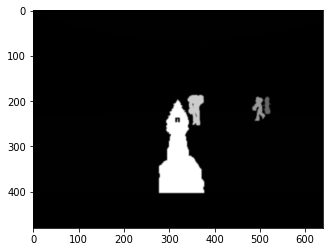

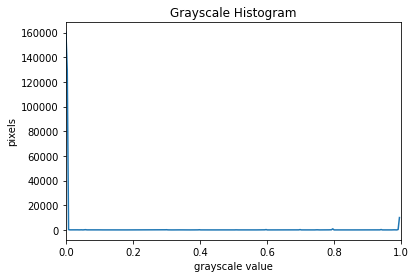

0.466796875


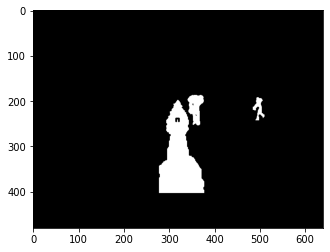

In [26]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.filters

# blur the image to denoise
blurred_image = skimage.filters.gaussian(episodes_images[0][27], sigma=1.0)

fig, ax = plt.subplots()
plt.imshow(blurred_image, cmap='gray')
plt.show()

histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))

plt.plot(bin_edges[0:-1], histogram)
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim(0, 1.0)
plt.show()

# perform automatic thresholding to produce a binary image
t = skimage.filters.threshold_otsu(blurred_image)
print(t)
binary_mask = blurred_image > t

fig, ax = plt.subplots()
plt.imshow(binary_mask, cmap='gray')
plt.show()


In [ ]:
#import matplotlib.pyplot as plt
#
#for data_index , frames  in enumerate(episodes_images):
#  for idx , image in enumerate(frames):
#    plt.imshow(image)
#    plt.show()